# Make token vocabulary
Train a tokenizer on the Tira ASR dataset

In [1005]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from transformers import WhisperTokenizer
import pandas as pd
import numpy as np
import seaborn
import string
from clap.encoders import *
from transformers import DebertaV2Tokenizer, AutoProcessor
import torch
from scipy.spatial.distance import cdist, cosine, squareform
from tqdm import tqdm
from unidecode import unidecode
import random

In [830]:
metadata='/Users/markjos/projects/malachor5/data/tira-clean/metadata.csv'

In [831]:
unk = "[UNK]"
trainer=trainers.BpeTrainer(vocab_size=1200, special_tokens=[unk], max_token_length=8, min_frequency=40)

In [832]:
df=pd.read_csv(metadata)
def get_text_corpus():
    train_df=df[df['split']=='train']
    for row in train_df['transcription']:
        yield row

In [833]:
tokenizer = Tokenizer(models.BPE())
tokenizer.train_from_iterator(get_text_corpus(), trainer=trainer)

In [834]:
i=random.randint(0,len(df))
line=df['transcription'].iloc[i]
encoding=tokenizer.encode(line)

line, encoding.tokens, encoding.ids

('jɔ́ ŋɔ́mɔ̀', ['j', 'ɔ́ ŋ', 'ɔ́mɔ̀'], [10, 107, 430])

In [835]:
tira_vocab=tokenizer.get_vocab()
tira_vocab, len(tira_vocab)

({'kɛ̀': 326,
  'ɔ': 25,
  'án á': 558,
  'mnà ': 657,
  'ó ': 84,
  'dɔ̀ɽɔ̀': 328,
  'ŋɔ̀ŋ': 506,
  'ŋáv': 284,
  'lɛ́ ': 470,
  'kámà': 704,
  'í ': 70,
  'ðɔ́mɔ̀': 679,
  'dɔ̀': 108,
  'lɛ': 320,
  'tɔ́': 686,
  'lí ': 211,
  'lâɾ': 319,
  'làr': 339,
  't̪ʊ̀': 434,
  'j': 10,
  'àt̪á ': 345,
  'lá': 77,
  'nɔ́ ŋ': 480,
  'ɾɛ': 138,
  'kɜ́': 695,
  'ŋg': 65,
  't̪ə́': 264,
  'ɲɛ̀làc': 639,
  'ŋà ': 317,
  'lt': 607,
  'ɛ́l': 435,
  'd̪ɔ̀ ': 614,
  'àv': 373,
  'wànì': 580,
  'láɾ': 371,
  'ɾɔ́ ': 648,
  'ɽɔ̀ ': 504,
  'nú': 553,
  'ŋ̀': 235,
  'ɜ̀ŋ': 548,
  'à nd̪': 135,
  'rì ': 641,
  'ðú ': 360,
  'ðùɽì ': 489,
  'ál': 158,
  'ŋʊ̀': 633,
  'ŋgá ': 304,
  'áŋà ': 443,
  'ðɔ̀là': 569,
  'lgàr': 517,
  'àn': 231,
  'úɽ': 256,
  'gàɾ': 550,
  'ág': 327,
  'ɜ': 28,
  'r': 17,
  'və́lɛ̂ð': 121,
  'dɛ̀': 168,
  'lə́v': 483,
  'vəlɛð': 395,
  'lò': 90,
  'ɛ̄': 700,
  'i ': 574,
  'ɲár': 446,
  'gɛ́ ': 355,
  'ðúɽ': 554,
  'nɛ̀ ŋə̀': 257,
  'lèɲ': 3

In [836]:
vocab_lens=[]
for item in tira_vocab:
    vocab_lens.append(len(item.strip().replace('#', '')))
np.array(vocab_lens).mean()

3.6638537271448666

<Axes: >

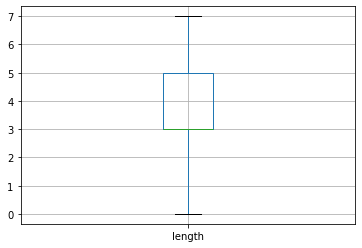

In [837]:
pd.DataFrame({'length':vocab_lens}).boxplot('length')

In [838]:
tira_id2tok={v:k for k, v in tira_vocab.items()}
tira_id2tok=pd.Series(tira_id2tok).sort_index().to_numpy()
tira_id2tok

array(['[UNK]', ' ', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'k',
       'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'ð', 'ŋ',
       'ɔ', 'ə', 'ɛ', 'ɜ', 'ɟ', 'ɭ', 'ɲ', 'ɽ', 'ɾ', 'ʃ', 'ʊ', '̀', '́',
       '̂', '̄', '̌', '̪', 'à', '́ ', 'ɛ̀', 'ɔ̀', 'á', 'ì', 'ə̀',
       'à ', 'ù', 't̪', 'ɔ́ ', 'ɔ́', 'í', 'nd', 'ɛ́', 'ú', 'ɔ̀ ',
       'bà', 'nd̪', 'ɔ̀bà', 'ə́', 'nɛ̀', 'lɛ̀', 'ŋg', 'ò', 'án',
       'á ', 'lɛ̀ð', 'í ', 'nà ', 'ɾɛ̀', 'íŋg', 'là', 'və́', 'ɛ́ ',
       'lá', 'ùnɛ̀', 'ɛ̀ ', 'və̀', 'nì', 'n ', 'íŋgán', 'ó ', 'kú',
       'l ', 'və̀lɛ̀ð', 'è', 'lə̀', 'lò', 'â', 'ì ', 't̪ɔ́', 'cə̀',
       'ŋà', 'kúk', 'wə̀', 'wə̀nì', 'cə̀lò', 'kúkù', 'ɛ̂', 'ɔ̀nà ',
       'ú ', 'ár', 'ìj', 'nɔ̀ ', 'ɔ́ ŋ', 'dɔ̀', 'nɛ̀ ', 'lɛ̂', 'ðà',
       'ɔ́m', 'là ', 'və́lɛ̂', 'ó', 'və́lɛ̀ð', 'ǎ', 'áŋ', 'ɔ́nà ',
       'rnɔ̀ ', 'və́lɛ̂ð', 'rɛ̀', 'ðə́', 't̪ɔ́ ', 'ðì', 'lì', 'nɛ',
       'lɛ́', 'ɔ́mɔ̀ ', 'nɛ́', 'dɔ̀ɽ', 'kúkù ', 'lù', 'kà', 'à

In [839]:
tira_ids=df['transcription'].apply(lambda s: tokenizer.encode(s).ids)
tira_tokenized=df['transcription'].apply(lambda s: tokenizer.encode(s).tokens)
tira_tokenized, tira_ids

(0                         [lə̀, və̀lɛ̀ð, ɛ́l , únɛ̀, ɾɛ̀]
 1                                        [kə̀ŋàc, î, í]
 2              [ŋ̀g, á, tɛ́, və́lɛ̂ð, ɔ́ nd̪, ɔ̀bà, gɛ̀]
 3        [ŋɔ́, ð, ɔ́ ŋ, á , və́lɛ̀ð, à , ðà, ŋàlà ...
 4                                    [ðə̀, və̀lè, ðɔ̀, ŋ]
                                ...                        
 20475        [ðá , nɛ́, l, ê,  , və̀lɛ̀ð, ɔ́ nd̪, ɔ̀bà]
 20476                                        [ŋə̀, vr, à]
 20477                       [ŋə̀, b, úr, ŋ, ɛ̀ , án, ó]
 20478    [lá , vŕ, ðì, t̪ɔ̀ , ku, ku, ŋu,  , ðɛ, dɔɽ...
 20479       [ùrnɔ̀ , kə̀, ŋ, a, cí , ápr, ì , kúkùŋ]
 Name: transcription, Length: 20480, dtype: object,
 0                                   [89, 87, 416, 177, 72]
 1                                           [670, 214, 54]
 2                        [323, 46, 259, 121, 160, 61, 153]
 3            [357, 23, 107, 68, 116, 49, 111, 285, 60, 61]
 4                                      [146, 66

In [840]:
tokenized_corpus_concat=np.concatenate(tira_tokenized)
tokenized_corpus_concat.shape

(149879,)

In [841]:
token_counts=pd.Series(tokenized_corpus_concat).value_counts()
token_counts[token_counts<=20].shape

(18,)

In [842]:
token_counts.mean()

211.39492242595205

In [843]:
pd.Series(tokenized_corpus_concat).unique().shape

(709,)

<Axes: >

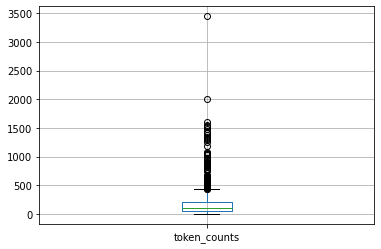

In [844]:
pd.DataFrame({'token_counts':token_counts}).boxplot('token_counts')

# Get predicted Whisper tokens
Run Whisper tokenizer on transcribed Tira ASR dataset

In [845]:
whisper_labels = '/Users/markjos/projects/malachor5/data/tira-asr/tira-clean-split-transcribed.csv'

whisper_df=pd.read_csv(whisper_labels)
whisper_df.head()

,path,croatian,split
0,HH01082021-m03s37ms011-m03s39ms552.wav,A prije jedi za hala.,train
1,HH01082021-m03s41ms371-m03s45ms023.wav,Apri-jadi-vanhala.,train
2,HH01082021-m04s43ms401-m04s46ms528.wav,A prije je vledo da hvala.,train
3,HH01082021-m04s48ms835-m04s51ms580.wav,A prije je vledo za hala.,train
4,HH01082021-m05s04ms737-m05s07ms762.wav,Apre je vledo za mala.,train


First, let's merge the Whisper and Tira metadata

In [846]:
df.shape, whisper_df.shape

((20480, 29), (20480, 3))

In [847]:
df_merge=pd.merge(df, whisper_df, on='path')
df_merge.shape

(20480, 31)

In [848]:
# df_merge.to_csv(metadata, index=False)

In [849]:
df=pd.read_csv(metadata)

Now let's get Whisper tokens

In [850]:
wh_tok=WhisperTokenizer.from_pretrained('openai/whisper-large-v3')

In [926]:
remove_punct = lambda s: ''.join(c for c in s if c not in string.punctuation)
remove_num = lambda s: ''.join(c for c in s if c not in string.digits)
df['croatian_nmzd']=df['croatian']\
    .str.lower()\
    .apply(remove_punct)\
    .apply(remove_num)
croatian_ids=df['croatian_nmzd'].apply(lambda s: wh_tok.encode(s, add_special_tokens=False))
croatian_ids

0                                      [287, 73, 836, 706]
1                                     [444, 64, 22392, 72]
2        [220, 273, 6908, 1506, 371, 73, 2032, 44254, 1...
3        [45843, 3080, 297, 3680, 779, 1506, 1120, 710,...
4                                    [710, 85, 20336, 298]
                               ...                        
20475               [1120, 408, 20445, 84, 375, 360, 9120]
20476                                         [5947, 4481]
20477                             [14828, 297, 432, 19816]
20478    [635, 331, 1479, 1506, 281, 1571, 350, 378, 34...
20479          [4038, 1771, 444, 64, 10236, 72, 1882, 470]
Name: croatian_nmzd, Length: 20480, dtype: object

In [852]:
croatian_tokenized=croatian_ids.apply(wh_tok.convert_ids_to_tokens)
croatian_tokenized

0                                          [Ġl, j, ub, av]
1                                         [Ġkn, a, ĠÄį, i]
2                   [Ġ, nd, ati, Ġje, Ġv, j, ero, jat, no]
3        [Ġngo, vo, Ġn, ga, vel, Ġje, Ġda, Ġz, an, ad, ...
4                                         [Ġz, v, lez, om]
                               ...                        
20475                   [Ġda, Ġne, Ġlev, u, Ġli, Ġdo, bro]
20476                                          [Ġnav, rat]
20477                                 [Ġbor, Ġn, ge, Ġano]
20478     [Ġla, ver, de, Ġje, Ġto, go, Ġk, od, ir, ava, o]
20479                    [Ġur, no, Ġkn, a, Äį, i, Ġap, ri]
Name: croatian, Length: 20480, dtype: object

In [853]:
croatian_tk_concat=np.concatenate(croatian_tokenized)
croatian_tk_concat.shape

(225166,)

In [854]:
croatian_tk_ct=pd.Series(croatian_tk_concat).value_counts()
croatian_tk_ct

Ġu       8106
v        7178
j        6581
Ġn       6441
ij       6384
         ... 
lon         1
lk          1
Ġmind       1
nar         1
Ġvere       1
Name: count, Length: 2429, dtype: int64

In [855]:
croatian_tk_ct.mean()

92.69905310827501

Let's make a list of only the Whisper tokens that are used and map their ids to their index in the list

<Axes: >

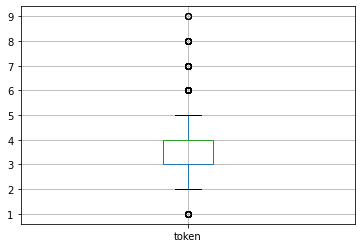

In [856]:
pd.DataFrame(data={'token':pd.Series(np.unique(croatian_tk_concat)).apply(len)}).boxplot('token')

<Axes: >

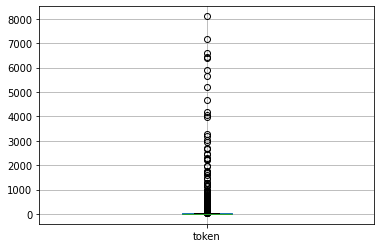

In [857]:
pd.DataFrame(data={'token':croatian_tk_ct}).boxplot('token')

In [858]:
croatian_i2whisper_tok=pd.Series(croatian_tk_concat).unique()
croatian_i2whisper_tok_id=pd.Series({i:wh_tok.convert_tokens_to_ids(tok) for i, tok in enumerate(croatian_i2whisper_tok)})
croatian_i2whisper_tok.shape, croatian_i2whisper_tok_id.shape

((2429,), (2429,))

In [860]:
croatian_i2whisper_tok[2428], croatian_i2whisper_tok_id[2428]

('Ġvere', 16443)

In [861]:
whisper_tok_id2croatian_i={v:i for i,v in enumerate(croatian_i2whisper_tok_id)}

In [862]:
croatian_i_shrunk=croatian_ids.apply(
    lambda l:[whisper_tok_id2croatian_i[i] for i in l]
)
croatian_i_shrunk

0                                             [0, 1, 2, 3]
1                                             [4, 5, 6, 7]
2                        [8, 9, 10, 11, 12, 1, 13, 14, 15]
3        [16, 17, 18, 19, 20, 11, 21, 22, 23, 24, 25, 2...
4                                         [22, 28, 29, 30]
                               ...                        
20475                       [21, 69, 601, 47, 42, 32, 197]
20476                                           [629, 401]
20477                                  [1149, 18, 75, 586]
20478    [103, 1139, 478, 11, 26, 420, 198, 121, 460, 2...
20479                     [346, 15, 4, 5, 54, 7, 347, 329]
Name: croatian, Length: 20480, dtype: object

Plop in code from `token_alignment.ipynb`

In [863]:
def get_prob_tensors(ipa_seqs, whisper_seqs):
    ipa_vocab_size = np.max(np.concatenate(ipa_seqs))+1
    whisper_vocab_size = np.max(np.concatenate(whisper_seqs))+1

    eps=1e-8 # avoid division by zero
    cooccurr_ct = np.full([whisper_vocab_size, ipa_vocab_size], eps)
    sum_sqd_dist = np.zeros_like(cooccurr_ct)
    return sum_sqd_dist, cooccurr_ct

def initialize_probs(ipa_seqs, whisper_seqs):
    eps=1e-8
    sum_sqd_dist, cooccurr_ct=get_prob_tensors(ipa_seqs, whisper_seqs)
    for ipa_seq, whisper_seq in zip(ipa_seqs, whisper_seqs):
        for i, ipa_token in enumerate(ipa_seq):
            i_relative=i/len(ipa_seq)
            for j, whisper_token in enumerate(whisper_seq):
                j_relative=j/len(whisper_seq)
                sum_sqd_dist[whisper_token,ipa_token]+=1/((i_relative-j_relative)**2+eps)
                cooccurr_ct[whisper_token,ipa_token]+=1
    prob_unnorm = torch.tensor(sum_sqd_dist/cooccurr_ct)
    prob_norm=torch.nn.functional.softmax((prob_unnorm),dim=1)
    return prob_norm.numpy()

In [864]:
sum_sqd_dist, cooccurr_ct = get_prob_tensors(tira_ids, croatian_i_shrunk)
sum_sqd_dist.shape, cooccurr_ct.shape

((2429, 711), (2429, 711))

In [865]:
prob_mat=initialize_probs(tira_ids, croatian_i_shrunk)

<Axes: >

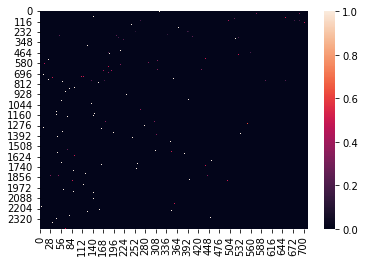

In [866]:
seaborn.heatmap(prob_mat)

# For each Tira token, get the most probable Whisper token

In [867]:
max_whisper_tokens=np.argmax(prob_mat, axis=0)
max_whisper_tokens.shape

(711,)

In [868]:
i=5
croatian_i2whisper_tok[max_whisper_tokens[i]], tira_id2tok[i]

('Ġlady', 'd')

In [869]:
np.unique(max_whisper_tokens).shape

(662,)

Let's make another matrix which is the cosine similarity of Whisper tokens to Tira tokens using CLAP-IPA phone embeddings

In [870]:
phone_encoder = PhoneEncoder.from_pretrained('anyspeech/clap-ipa-tiny-phone')
phone_encoder.eval()

clap_tok = DebertaV2Tokenizer.from_pretrained('charsiu/IPATokenizer')

ipa_input = clap_tok(
	['apri'],
	return_tensors='pt', # these kwargs avoid bugs
	return_token_type_ids=False,
	padding=True,
)

with torch.no_grad():
   phone_embed = phone_encoder(**ipa_input)['pooler_output']

In [871]:
tira_tok_input= clap_tok(
    [s.replace('#', '') for s in tira_id2tok.tolist()],
    return_tensors='pt', # these kwargs avoid bugs
    return_token_type_ids=False,
    padding=True,
)

with torch.no_grad():
    tira_id2_tok_embed=phone_encoder(**tira_tok_input)['pooler_output']

tira_id2_tok_embed.shape

torch.Size([711, 384])

In [872]:
croatian_tok_input= clap_tok(
    [s.replace('Ġ', '') for s in croatian_i2whisper_tok.tolist()],
    return_tensors='pt', # these kwargs avoid bugs
    return_token_type_ids=False,
    padding=True,
)

with torch.no_grad():
    croatian_id2_tok_embed=phone_encoder(**croatian_tok_input)['pooler_output']

croatian_id2_tok_embed.shape

torch.Size([2429, 384])

In [873]:
cos_distance = cdist(croatian_id2_tok_embed,tira_id2_tok_embed,cosine)
similarity=-1*(cos_distance-1)
similarity.shape

(2429, 711)

In [874]:
similarity=torch.tensor(similarity).softmax(dim=1).numpy()

<Axes: >

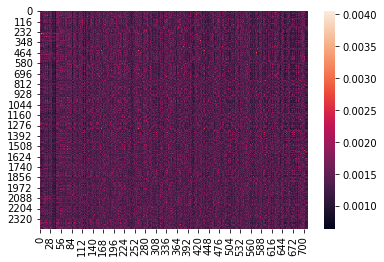

In [875]:
seaborn.heatmap(similarity)

In [876]:
max_whisper_tokens_embeds=np.argmax(similarity, axis=0)
max_whisper_tokens_embeds.shape

(711,)

In [877]:
i=700
croatian_i2whisper_tok[max_whisper_tokens_embeds[i]], tira_id2tok[i]

('Ī', 'ɛ̄')

In [878]:
np.unique(max_whisper_tokens_embeds).shape

(321,)

What if we do the opposite direction?

In [879]:
max_tira_tokens=np.argmax(prob_mat, axis=1)
max_tira_tokens.shape

(2429,)

In [880]:
max_tira_tokens_embeds=np.argmax(similarity, axis=1)
max_tira_tokens_embeds.shape

(2429,)

In [881]:
np.unique(max_tira_tokens).shape, np.unique(max_tira_tokens_embeds).shape

((578,), (404,))

In [1020]:
l_unique=np.zeros(1_000)
l_shape_mismatch=np.zeros(1_000)
tira_token_lens=pd.Series(tira_id2tok).apply(len)
whisper_token_lens=pd.Series(croatian_i2whisper_tok).apply(lambda s:s.replace('Ġ', '')).apply(len)
for i in tqdm(range(1_000)):
    l=i/1_000
    combined_prob=l*prob_mat+(1-l)*similarity
    max_whisper_tokens_combined=np.argmax(combined_prob, axis=0)
    l_unique[i]=np.unique(max_whisper_tokens_combined).shape[0]
    max_whisper_token_lens=pd.Series(max_whisper_tokens_combined).apply(lambda wh_i:whisper_token_lens[wh_i])
    l_shape_mismatch[i]=np.square(tira_token_lens-max_whisper_token_lens).mean()
uniquest_l=np.argmax(l_unique)
shapliest_l=np.argmin(l_shape_mismatch)
uniquest_l, l_unique[uniquest_l], shapliest_l, l_shape_mismatch[shapliest_l]

100%|██████████| 1000/1000 [00:22<00:00, 44.98it/s]


(40, 681.0, 0, 2.779184247538678)

<Axes: >

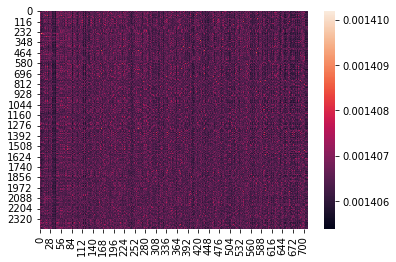

In [1023]:
l=0#uniquest_l/1_000
combined_prob=l*prob_mat+(1-l)*similarity
combined_prob=torch.tensor(combined_prob).softmax(dim=1).numpy()
seaborn.heatmap(combined_prob)

In [1024]:
max_whisper_tokens_combined=np.argmax(combined_prob, axis=0)
np.unique(max_whisper_tokens_combined).shape

(321,)

In [1025]:
tira_id2whisper_id={}
combined_prob_copy=similarity.copy()#combined_prob.copy()
for i, col in enumerate(combined_prob_copy.T):
    max_whisper_i=np.argmax(col)
    combined_prob_copy[max_whisper_i]=float('-inf')
    tira_id2whisper_id[i]=croatian_i2whisper_tok_id[max_whisper_i]
tira_id2whisper_id

{0: 220,
 1: 276,
 2: 64,
 3: 65,
 4: 1914,
 5: 274,
 6: 68,
 7: 290,
 8: 71,
 9: 72,
 10: 73,
 11: 350,
 12: 287,
 13: 275,
 14: 297,
 15: 78,
 16: 280,
 17: 81,
 18: 262,
 19: 83,
 20: 84,
 21: 371,
 22: 261,
 23: 85,
 24: 6415,
 25: 277,
 26: 107,
 27: 308,
 28: 79,
 29: 66,
 30: 75,
 31: 9616,
 32: 367,
 33: 48759,
 34: 1878,
 35: 344,
 36: 67,
 37: 74,
 38: 256,
 39: 15696,
 40: 70,
 41: 16364,
 42: 257,
 43: 272,
 44: 230,
 45: 129,
 46: 40079,
 47: 741,
 48: 675,
 49: 1641,
 50: 128,
 51: 392,
 52: 1986,
 53: 18728,
 54: 361,
 55: 273,
 56: 415,
 57: 86,
 58: 1106,
 59: 31568,
 60: 580,
 61: 19481,
 62: 324,
 63: 40857,
 64: 306,
 65: 872,
 66: 1289,
 67: 969,
 68: 22714,
 69: 18320,
 70: 4247,
 71: 629,
 72: 319,
 73: 3957,
 74: 635,
 75: 1241,
 76: 10012,
 77: 3505,
 78: 44257,
 79: 5096,
 80: 4221,
 81: 3867,
 82: 77,
 83: 17017,
 84: 263,
 85: 17807,
 86: 285,
 87: 7363,
 88: 269,
 89: 476,
 90: 2295,
 91: 1445,
 92: 20601,
 93: 281,
 94: 496,
 95: 23165,
 96: 2034,
 97: 622

In [1026]:
len(tira_id2whisper_id.values()), len(set(tira_id2whisper_id.values()))

(711, 711)

In [1027]:
whisper_id2tira_id={v:k for k,v in tira_id2whisper_id.items()}

In [1028]:
tira_tok2whisper_tok={
    tira_id2tok[k]:wh_tok.decode(v)
    for k,v in tira_id2whisper_id.items()
}
tira_tok2whisper_tok

{'[UNK]': ' ',
 ' ': ' h',
 'a': 'a',
 'b': 'b',
 'c': 'cc',
 'd': ' d',
 'e': 'e',
 'g': ' g',
 'h': 'h',
 'i': 'i',
 'j': 'j',
 'k': ' k',
 'l': ' l',
 'm': ' m',
 'n': ' n',
 'o': 'o',
 'p': ' p',
 'r': 'r',
 's': ' s',
 't': 't',
 'u': 'u',
 'v': ' v',
 'w': ' w',
 'ð': 'v',
 'ŋ': ' ng',
 'ɔ': ' o',
 'ə': '�',
 'ɛ': ' e',
 'ɜ': 'p',
 'ɟ': 'c',
 'ɭ': 'l',
 'ɲ': ' nin',
 'ɽ': ' r',
 'ɾ': 'rh',
 'ʃ': 'ps',
 'ʊ': ' u',
 '̀': 'd',
 '́': 'k',
 '̂': ' t',
 '̄': ' kg',
 '̌': 'g',
 '̪': ' tv',
 'à': ' a',
 '́ ': ' b',
 'ɛ̀': '�',
 'ɔ̀': '�',
 'á': ' aa',
 'ì': ' i',
 'ə̀': 'he',
 'à ': 'ha',
 'ù': '�',
 't̪': 'th',
 'ɔ́ ': 'oo',
 'ɔ́': 'ooo',
 'í': ' j',
 'nd': 'nd',
 'ɛ́': ' he',
 'ú': 'w',
 'ɔ̀ ': ' ho',
 'bà': ' baba',
 'nd̪': 'nt',
 'ɔ̀bà': 'oba',
 'ə́': ' ha',
 'nɛ̀': ' neh',
 'lɛ̀': 'le',
 'ŋg': 'ng',
 'ò': 'ho',
 'án': 'ann',
 'á ': 'aaa',
 'lɛ̀ð': 'bled',
 'í ': 'ih',
 'nà ': 'na',
 'ɾɛ̀': ' re',
 'íŋg': ' ing',
 'là': ' la',
 'və́': ' ve',
 'ɛ́ ': ' ej',
 'lá': 'll

In [1029]:
def transliterate_to_whisper(tira_str):
    tira_tokens = tokenizer.encode(tira_str).ids
    whisper_tokens = [tira_id2whisper_id[t] for t in tira_tokens]
    whisper_str = wh_tok.decode(whisper_tokens)
    return whisper_str
i=random.randint(0,len(df))
df['transcription'][i], transliterate_to_whisper(df['transcription'][i])

('kúkù ŋgápɔ́t̪ìðɔ̀ ɛ́nà nɛ̀ lə̀vɛ̀r', 'ukuuga pooo ti vo hena ne lever')

In [1039]:
def transliterate_to_whisper_ids(tira_str):
    tira_tokens = tokenizer.encode(tira_str).ids
    whisper_tokens = [tira_id2whisper_id[t] for t in tira_tokens]
    return whisper_tokens

In [1038]:
def transliterate_to_tira(whisper_str):
    whisper_tokens=wh_tok.tokenize(whisper_str)
    whisper_ids=wh_tok.convert_tokens_to_ids(whisper_tokens)
    tira_ids=[whisper_id2tira_id.get(i, wh_tok.decode(i)[0]) for i in whisper_ids]
    tira_str=''.join([tokenizer.decode([t]) if type(t) is int else t for t in tira_ids])
    return tira_str
i=random.randint(0,len(df))
tira_str = df['transcription'][i]
whisper_str=transliterate_to_whisper(tira_str)
tira_str, whisper_str, transliterate_to_tira(whisper_str)

('lìdɔ̀t̪ɔ́ dún únɛ̀ɾɛ̀', ' li doto dununa re', 'lìdɔodún únɛ̀ɾɛ̀')

The conversion is lossy, bc nothing's constraining Whisper to only use the tokens in the vocabulary. Let's address that later.

In [999]:
df['tira_transliterated']=df['transcription'].apply(transliterate_to_whisper)
df['tira_transliterated']

0                      le valideluna re
1                           correctik j
2                 neg aa tealedondobace
3        ingovongaaailedha va malantoba
4                          be volevo ng
                      ...              
20475           za naj lņ h validondoba
20476                          neo pr a
20477               neob ur ng ihann ou
20478     bla vicvi torkuku gu hzegor o
20479      monoche nga chi apl sj komun
Name: tira_transliterated, Length: 20480, dtype: object

In [1040]:
df['tira_transliterated_ids']=df['transcription'].apply(transliterate_to_whisper_ids)
df['tira_transliterated_ids']

0                              [476, 7363, 338, 5051, 319]
1                                        [3006, 1035, 361]
2                [2485, 40079, 535, 5573, 684, 19481, 384]
3        [18459, 85, 556, 22714, 7292, 1641, 2773, 3750...
4                                 [650, 49877, 3080, 6415]
                               ...                        
20475     [7949, 11212, 287, 43657, 276, 7363, 684, 19481]
20476                                    [41977, 582, 257]
20477             [41977, 65, 4038, 6415, 5096, 969, 2820]
20478    [16379, 26031, 4917, 3930, 5279, 5279, 695, 27...
20479    [35624, 1876, 6415, 64, 13228, 25522, 20601, 4...
Name: tira_transliterated_ids, Length: 20480, dtype: object

In [1041]:
df.to_csv(metadata)

In [1001]:
metadata

'/Users/markjos/projects/malachor5/data/tira-clean/metadata.csv'